In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import joblib
from imblearn.over_sampling import SMOTE
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
X_train = np.load('../data/X_train_processed.npy')
X_test = np.load('../data/X_test_processed.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train shape: {y_train.shape}, Test Shape: {y_test.shape}")

Train shape: (202944, 21), Test shape: (50736, 21)
Train shape: (202944,), Test Shape: (50736,)


In [3]:
# ───────────────────────────────────────────────────────────────
# Apply SMOTE to balance the training set
# ───────────────────────────────────────────────────────────────

print("Original train class distribution:")
print(pd.Series(y_train).value_counts(normalize=True).round(3) * 100)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True).round(3) * 100)
# Now ~50/50 balanced

Original train class distribution:
0    86.1
1    13.9
Name: proportion, dtype: float64

Class distribution after SMOTE:
0    50.0
1    50.0
Name: proportion, dtype: float64


In [4]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )
}

models_smote = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, eval_metric='auc', random_state=42, n_jobs=-1)
}

In [5]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name, show_plots=True):
    print(f"\n=== {name} ===")
    
    # Fit
    model.fit(X_tr, y_tr)
    
    # Predict
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics at default threshold 0.5
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    auc = roc_auc_score(y_te, y_prob) if y_prob is not None else None
    
    print(f"Default threshold (0.5):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if auc:
        print(f"AUC-ROC:   {auc:.4f}")
    
    # Classification report
    print("\nClassification Report (default threshold):")
    print(classification_report(y_te, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)'], zero_division=0))
    
    # Confusion matrix
    if show_plots:
        cm = confusion_matrix(y_te, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix - {name} (threshold=0.5)")
        plt.show()
    
    # ROC curve
    if y_prob is not None and show_plots:
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
    
    # ───────────────────────────────────────────────────────────────
    # Precision-Recall Curve + Optimal Threshold (max F1)
    # ───────────────────────────────────────────────────────────────
    if y_prob is not None:
        prec, rec, thresh = precision_recall_curve(y_te, y_prob)
        
        # Compute F1 for each threshold
        f1_scores = 2 * (prec * rec) / (prec + rec + 1e-10)  # avoid div by zero
        best_idx = np.argmax(f1_scores)
        best_thresh = thresh[best_idx]
        best_prec = prec[best_idx]
        best_rec = rec[best_idx]
        best_f1 = f1_scores[best_idx]
        
        # Apply optimal threshold
        y_pred_opt = (y_prob >= best_thresh).astype(int)
        acc_opt = accuracy_score(y_te, y_pred_opt)
        prec_opt = precision_score(y_te, y_pred_opt, zero_division=0)
        rec_opt = recall_score(y_te, y_pred_opt, zero_division=0)
        f1_opt = f1_score(y_te, y_pred_opt, zero_division=0)
        
        print(f"\nPrecision-Recall optimal threshold: {best_thresh:.4f}")
        print(f"Best F1 at this threshold: {best_f1:.4f}")
        print(f"Precision: {best_prec:.4f}   Recall: {best_rec:.4f}")
        print(f"Accuracy at optimal: {acc_opt:.4f}")
        
        if show_plots:
            # Plot PR curve with optimal point highlighted
            plt.figure()
            plt.plot(rec, prec, label='PR curve')
            plt.scatter(best_rec, best_prec, c='red', s=100, label=f'Best F1 = {best_f1:.3f} @ thresh={best_thresh:.3f}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve - {name}')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # Return both default and optimized metrics
        return {
            'name': name,
            'acc_0.5': acc, 'prec_0.5': prec, 'rec_0.5': rec, 'f1_0.5': f1, 'auc': auc,
            'best_thresh': best_thresh,
            'acc_opt': acc_opt, 'prec_opt': prec_opt, 'rec_opt': rec_opt, 'f1_opt': f1_opt
        }
    
    return {
        'name': name,
        'acc_0.5': acc, 'prec_0.5': prec, 'rec_0.5': rec, 'f1_0.5': f1, 'auc': auc
    }


=== No Resampling (class_weight='balanced') ===

=== Logistic Regression ===
Default threshold (0.5):
Accuracy:  0.7316
Precision: 0.3108
Recall:    0.7611
F1-Score:  0.4414
AUC-ROC:   0.8196

Classification Report (default threshold):
                 precision    recall  f1-score   support

No Diabetes (0)       0.95      0.73      0.82     43667
   Diabetes (1)       0.31      0.76      0.44      7069

       accuracy                           0.73     50736
      macro avg       0.63      0.74      0.63     50736
   weighted avg       0.86      0.73      0.77     50736



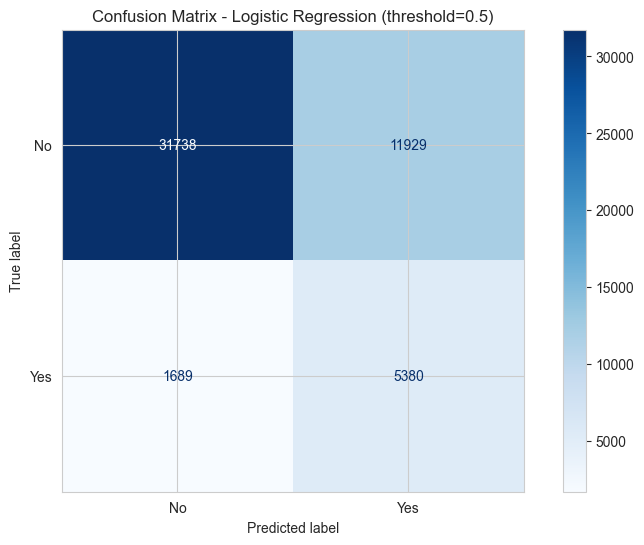

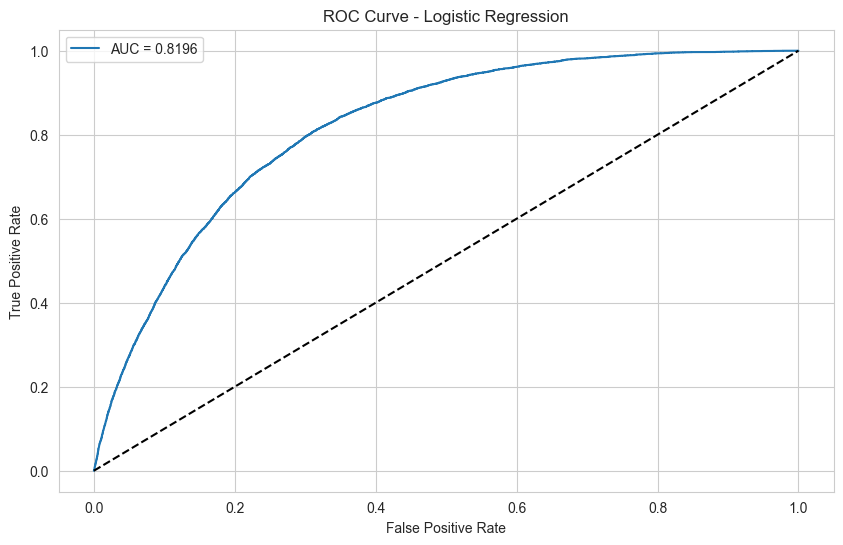


Precision-Recall optimal threshold: 0.5968
Best F1 at this threshold: 0.4591
Precision: 0.3537   Recall: 0.6543
Accuracy at optimal: 0.7852


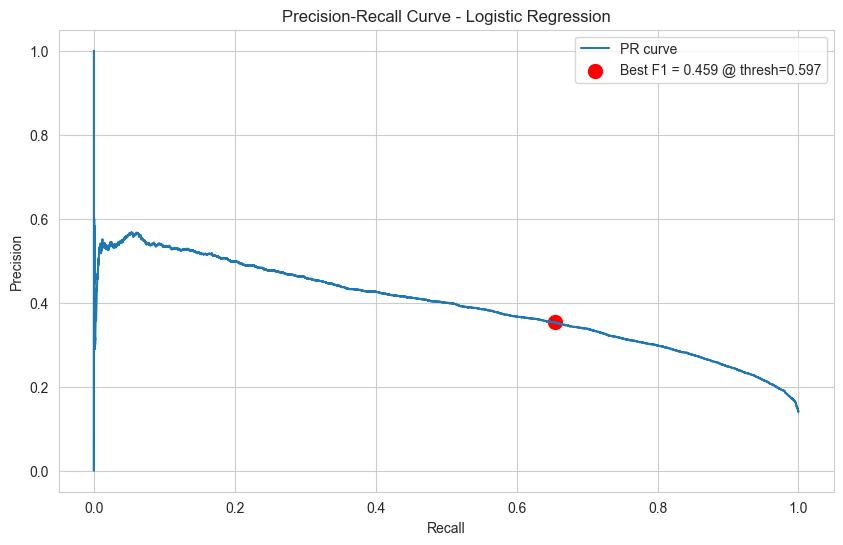


=== Random Forest ===
Default threshold (0.5):
Accuracy:  0.8564
Precision: 0.4555
Recall:    0.1587
F1-Score:  0.2354
AUC-ROC:   0.7907

Classification Report (default threshold):
                 precision    recall  f1-score   support

No Diabetes (0)       0.88      0.97      0.92     43667
   Diabetes (1)       0.46      0.16      0.24      7069

       accuracy                           0.86     50736
      macro avg       0.67      0.56      0.58     50736
   weighted avg       0.82      0.86      0.83     50736



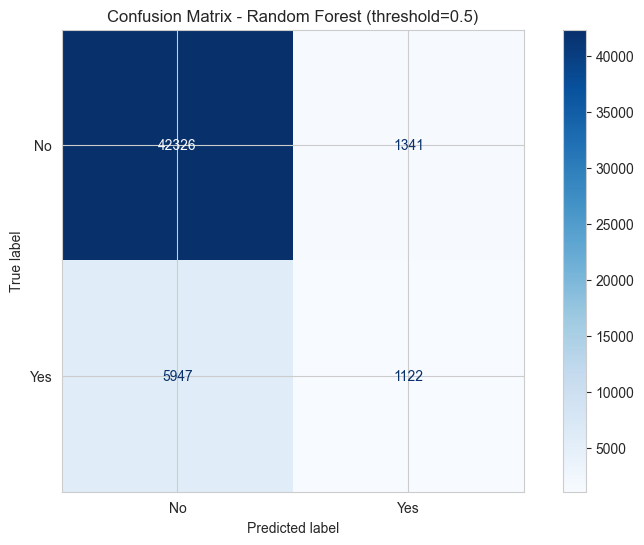

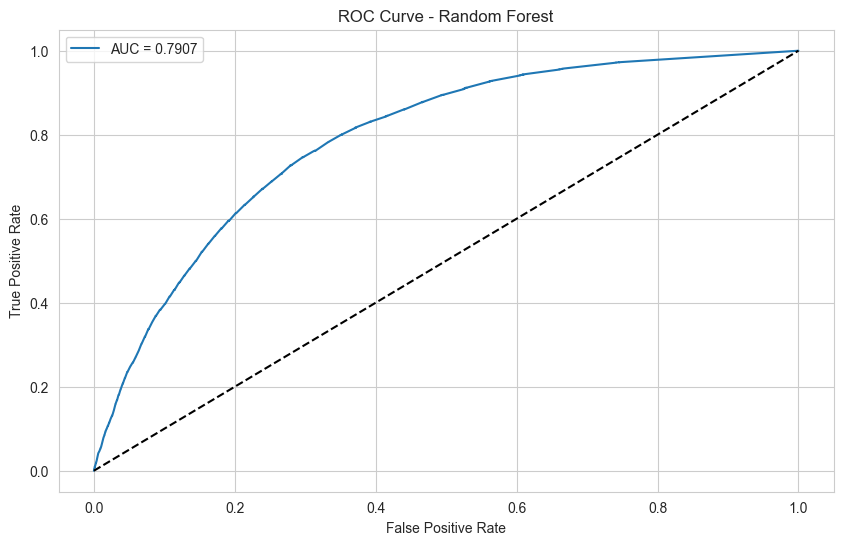


Precision-Recall optimal threshold: 0.2200
Best F1 at this threshold: 0.4292
Precision: 0.3305   Recall: 0.6120
Accuracy at optimal: 0.7732


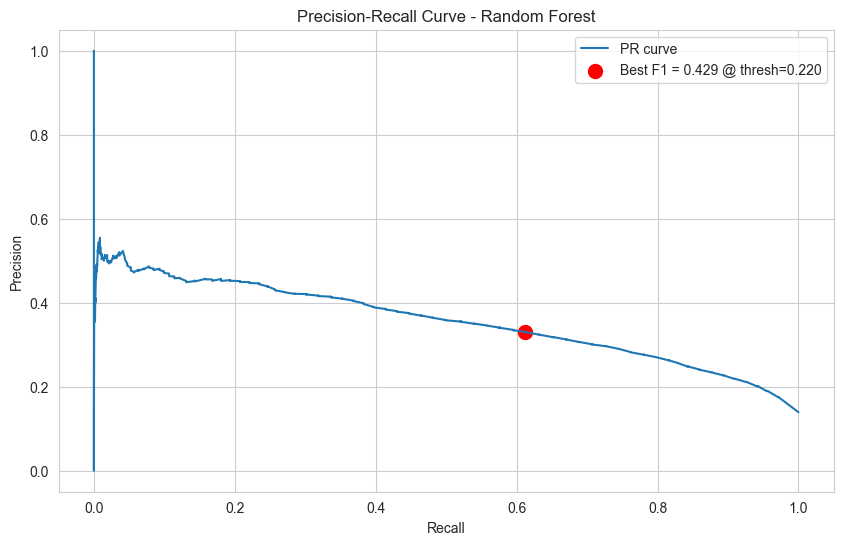


=== XGBoost ===
Default threshold (0.5):
Accuracy:  0.7284
Precision: 0.3100
Recall:    0.7745
F1-Score:  0.4428
AUC-ROC:   0.8218

Classification Report (default threshold):
                 precision    recall  f1-score   support

No Diabetes (0)       0.95      0.72      0.82     43667
   Diabetes (1)       0.31      0.77      0.44      7069

       accuracy                           0.73     50736
      macro avg       0.63      0.75      0.63     50736
   weighted avg       0.86      0.73      0.77     50736



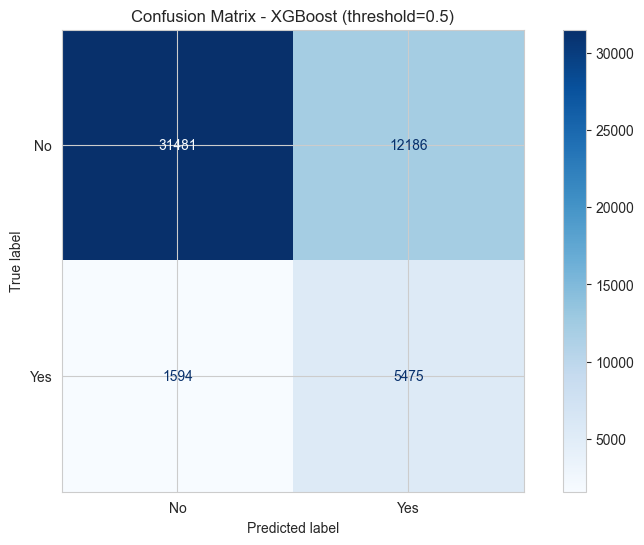

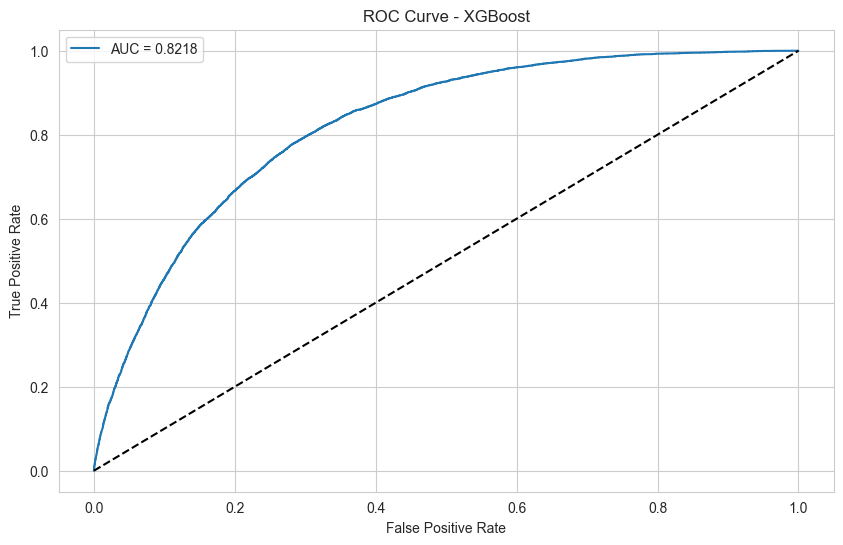


Precision-Recall optimal threshold: 0.6603
Best F1 at this threshold: 0.4649
Precision: 0.3862   Recall: 0.5840
Accuracy at optimal: 0.8127


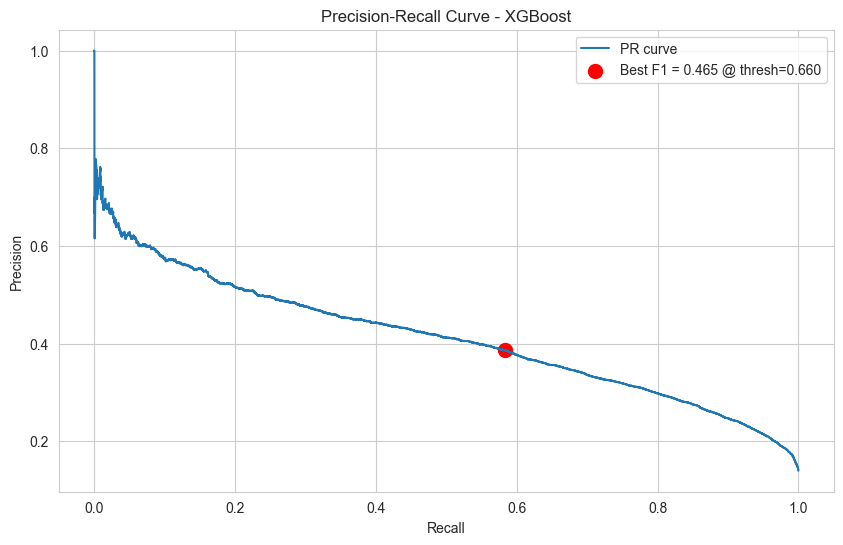


Summary Table (No SMOTE - default threshold 0.5):
                  name  acc_0.5  \
2              XGBoost   0.7284   
0  Logistic Regression   0.7316   
1        Random Forest   0.8564   

                                            prec_0.5  \
2  [0.13932907600126143, 0.1393318222134621, 0.13...   
0  [0.13932907600126143, 0.1393318222134621, 0.13...   
1  [0.13932907600126143, 0.17400875483919942, 0.1...   

                                             rec_0.5  f1_0.5     auc  
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.4428  0.8218  
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.4414  0.8196  
1  [1.0, 0.9728391568821616, 0.9728391568821616, ...  0.2354  0.7907  

Optimized Threshold Results (max F1):
                  name  best_thresh  acc_opt  prec_opt  rec_opt  f1_opt
2              XGBoost       0.6603   0.8127    0.3862   0.5840  0.4649
0  Logistic Regression       0.5968   0.7852    0.3537   0.6543  0.4591
1        Random Forest       0.2200   0.7732

In [6]:
print("\n=== No Resampling (class_weight='balanced') ===")
results = []
for name, model in models.items():
    res = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(res)

results_df = pd.DataFrame(results)
print("\nSummary Table (No SMOTE - default threshold 0.5):")
print(results_df[['name', 'acc_0.5', 'prec_0.5', 'rec_0.5', 'f1_0.5', 'auc']].sort_values('f1_0.5', ascending=False).round(4))

print("\nOptimized Threshold Results (max F1):")
print(results_df[['name', 'best_thresh', 'acc_opt', 'prec_opt', 'rec_opt', 'f1_opt']].sort_values('f1_opt', ascending=False).round(4))


=== With SMOTE (Balanced Training Data) ===

=== Logistic Regression + SMOTE ===
Default threshold (0.5):
Accuracy:  0.7325
Precision: 0.3113
Recall:    0.7592
F1-Score:  0.4416
AUC-ROC:   0.8173

Classification Report (default threshold):
                 precision    recall  f1-score   support

No Diabetes (0)       0.95      0.73      0.82     43667
   Diabetes (1)       0.31      0.76      0.44      7069

       accuracy                           0.73     50736
      macro avg       0.63      0.74      0.63     50736
   weighted avg       0.86      0.73      0.77     50736



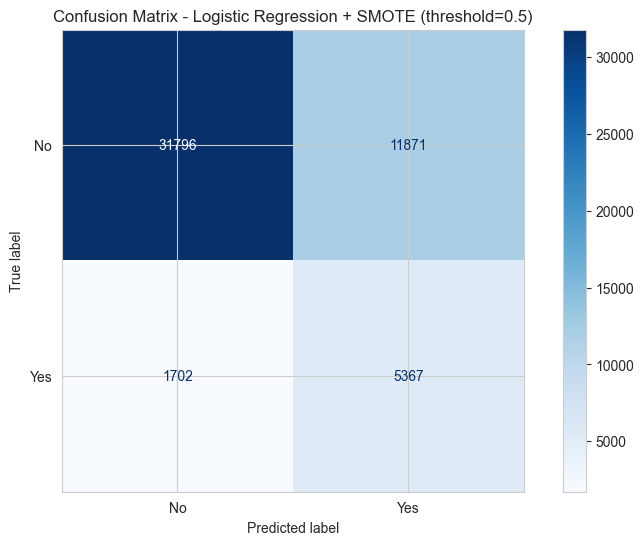

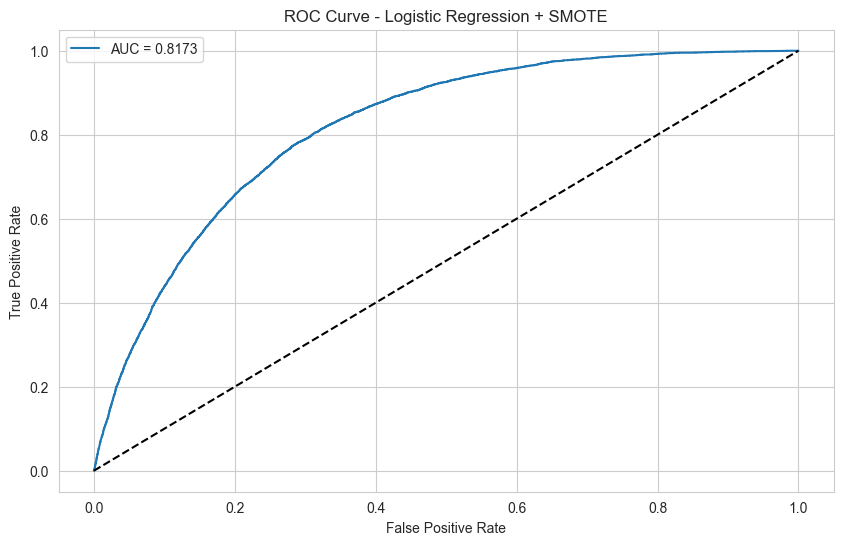


Precision-Recall optimal threshold: 0.6213
Best F1 at this threshold: 0.4547
Precision: 0.3596   Recall: 0.6182
Accuracy at optimal: 0.7934


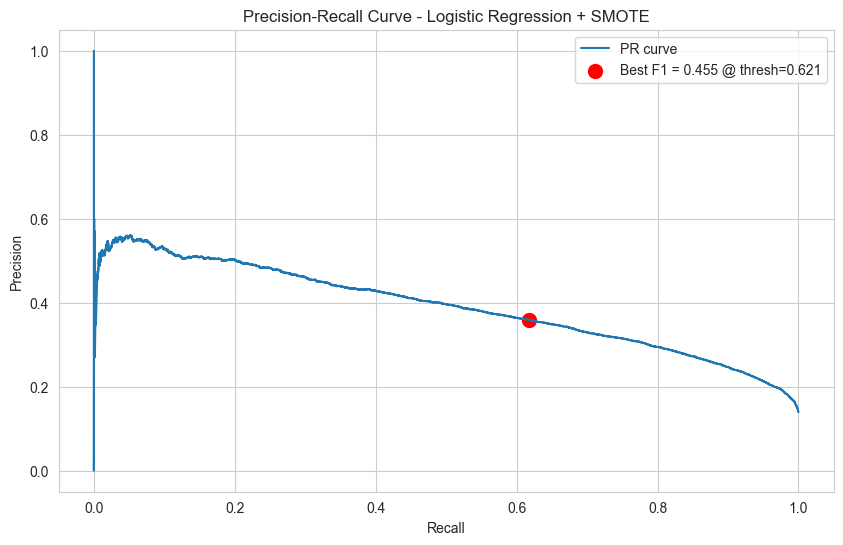


=== Random Forest + SMOTE ===
Default threshold (0.5):
Accuracy:  0.8496
Precision: 0.4322
Recall:    0.2524
F1-Score:  0.3187
AUC-ROC:   0.7925

Classification Report (default threshold):
                 precision    recall  f1-score   support

No Diabetes (0)       0.89      0.95      0.92     43667
   Diabetes (1)       0.43      0.25      0.32      7069

       accuracy                           0.85     50736
      macro avg       0.66      0.60      0.62     50736
   weighted avg       0.82      0.85      0.83     50736



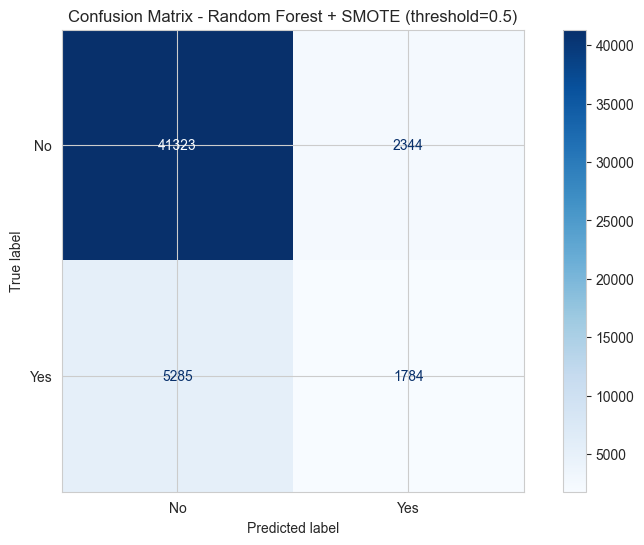

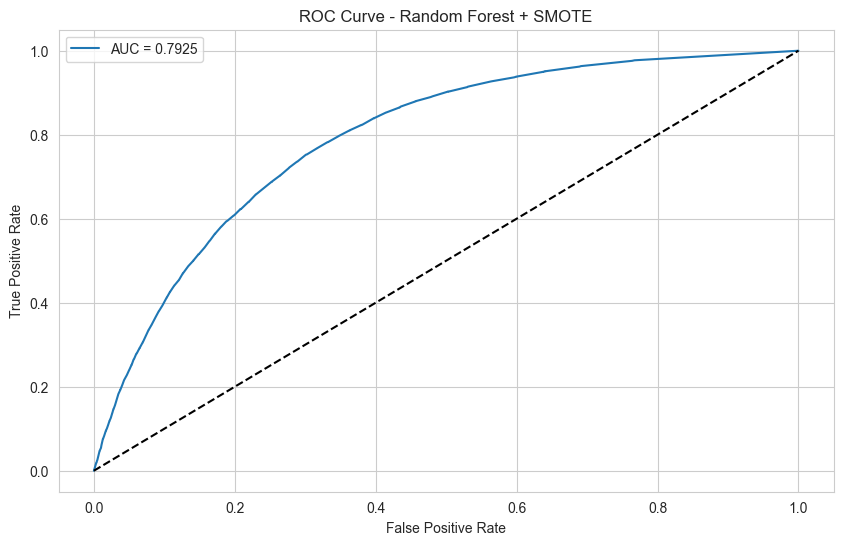


Precision-Recall optimal threshold: 0.2783
Best F1 at this threshold: 0.4312
Precision: 0.3385   Recall: 0.5939
Accuracy at optimal: 0.7818


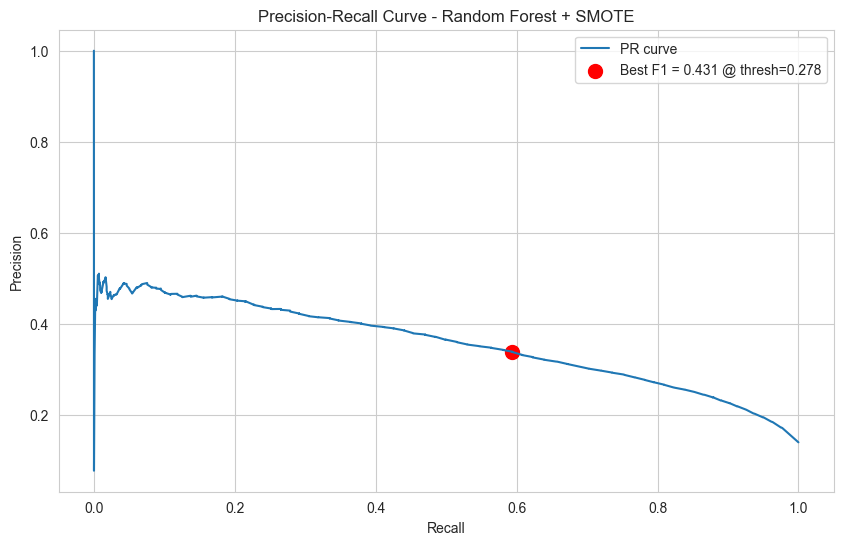


=== XGBoost + SMOTE ===
Default threshold (0.5):
Accuracy:  0.8629
Precision: 0.5204
Recall:    0.2000
F1-Score:  0.2890
AUC-ROC:   0.8215

Classification Report (default threshold):
                 precision    recall  f1-score   support

No Diabetes (0)       0.88      0.97      0.92     43667
   Diabetes (1)       0.52      0.20      0.29      7069

       accuracy                           0.86     50736
      macro avg       0.70      0.59      0.61     50736
   weighted avg       0.83      0.86      0.84     50736



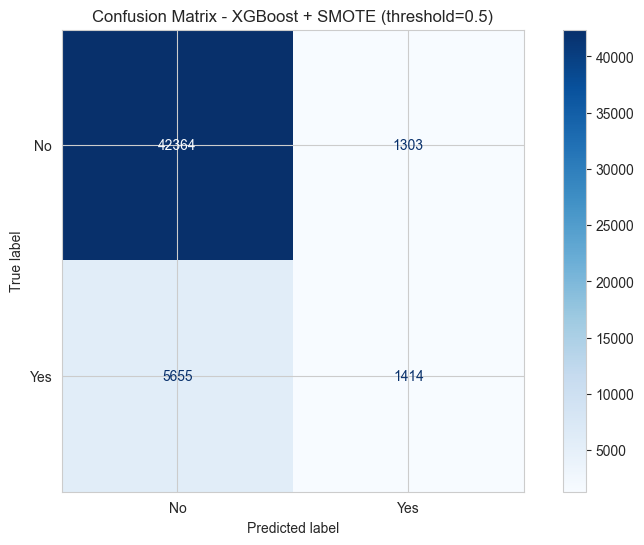

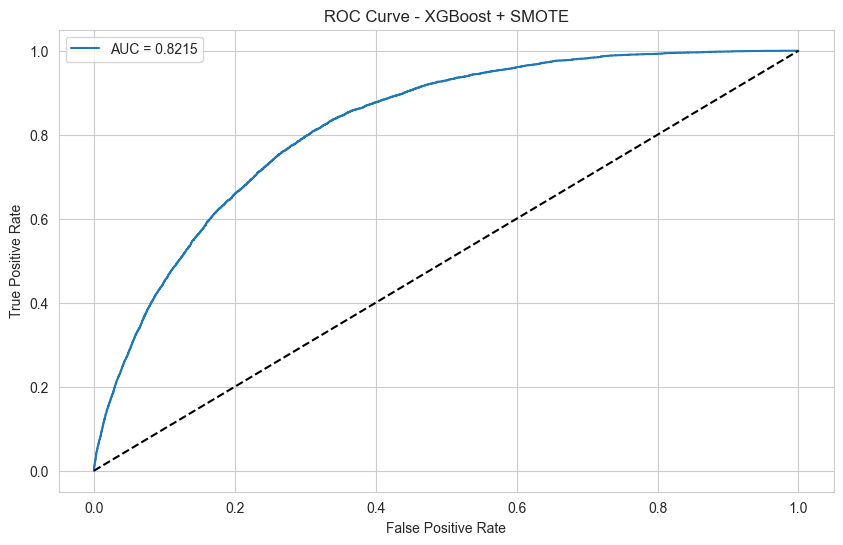


Precision-Recall optimal threshold: 0.2504
Best F1 at this threshold: 0.4590
Precision: 0.3645   Recall: 0.6197
Accuracy at optimal: 0.7965


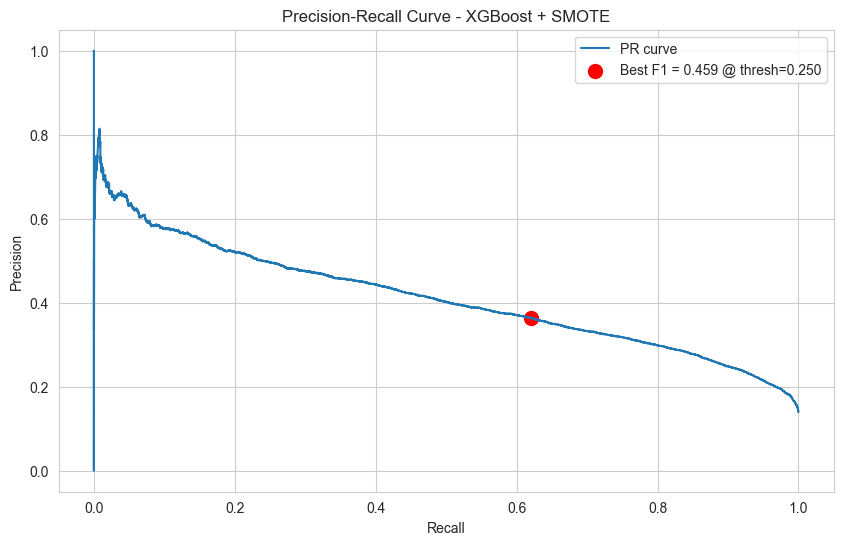


Full Summary Table - Default threshold (0.5):
                          name  acc_0.5  \
2                      XGBoost   0.7284   
3  Logistic Regression + SMOTE   0.7325   
0          Logistic Regression   0.7316   
4        Random Forest + SMOTE   0.8496   
5              XGBoost + SMOTE   0.8629   
1                Random Forest   0.8564   

                                            prec_0.5  \
2  [0.13932907600126143, 0.1393318222134621, 0.13...   
3  [0.13932907600126143, 0.1393318222134621, 0.13...   
0  [0.13932907600126143, 0.1393318222134621, 0.13...   
4  [0.13932907600126143, 0.17090972067591975, 0.1...   
5  [0.13932907600126143, 0.1393318222134621, 0.13...   
1  [0.13932907600126143, 0.17400875483919942, 0.1...   

                                             rec_0.5  f1_0.5     auc  
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.4428  0.8218  
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  0.4416  0.8173  
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [7]:
print("\n=== With SMOTE (Balanced Training Data) ===")
results_smote = []
for name, model in models_smote.items():
    res = evaluate_model(model, X_train_smote, y_train_smote, X_test, y_test, f"{name} + SMOTE")
    results_smote.append(res)

all_results = results + results_smote
results_df_all = pd.DataFrame(all_results)

print("\nFull Summary Table - Default threshold (0.5):")
print(results_df_all[['name', 'acc_0.5', 'prec_0.5', 'rec_0.5', 'f1_0.5', 'auc']].sort_values('f1_0.5', ascending=False).round(4))

print("\nFull Summary Table - Optimized threshold (max F1):")
print(results_df_all[['name', 'best_thresh', 'acc_opt', 'prec_opt', 'rec_opt', 'f1_opt']].sort_values('f1_opt', ascending=False).round(4))

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    XGBClassifier(scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(), random_state=42),
    X_train, y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"\nXGBoost 5-Fold CV AUC (no SMOTE): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


XGBoost 5-Fold CV AUC (no SMOTE): 0.8238 ± 0.0022


In [9]:
best_model_name = "Logistic Regression"
best_model = models['Logistic Regression']  # ← non-SMOTE version

os.makedirs('../models', exist_ok=True)
model_path = f'../models/best_diabetes_model_{best_model_name.replace(" ", "_")}.joblib'
joblib.dump(best_model, model_path)
print(f"\nBest model saved: {model_path}")

# Preprocessor check
preprocessor_path = '../models/diabetes_preprocessor.joblib'
if os.path.exists(preprocessor_path):
    print(f"Preprocessor confirmed: {preprocessor_path}")
else:
    print("Warning: Preprocessor missing — resave from Notebook 02")

# Save test predictions (using default threshold)
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'true_label': y_test,
    'predicted_default': y_pred_best,
    'prob_diabetes': y_prob_best
})

pred_path = f'../data/test_predictions_{best_model_name.replace(" ", "_")}.csv'
results_df.to_csv(pred_path, index=False)
print(f"Test predictions saved: {pred_path}")


Best model saved: ../models/best_diabetes_model_Logistic_Regression.joblib
Preprocessor confirmed: ../models/diabetes_preprocessor.joblib
Test predictions saved: ../data/test_predictions_Logistic_Regression.csv
